<a href="https://colab.research.google.com/github/Ziqi-Li/GEO4162C/blob/main/notebooks/set_covering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Spatial Optimization (2): Set Covering Problem

In this model, a facility can serve all demand nodes that are within a given coverage distance Dc from the facility. The problem is the place the **minimum** number of facilities so as to ensure that all demand nodes can be served. We assume there are no capacity constraints at the facilities.

Refer to pg. 28 in the lecture slide.

In [1]:
pip install -q pulp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 81.7 MB/s eta 0:00:00


In [2]:
from pulp import *
import numpy as np
import geopandas as gp
from scipy.spatial.distance import cdist

import matplotlib.pyplot as plt

In [3]:
#read a sample shapefile
georgia_shp = gp.read_file("https://raw.githubusercontent.com/Ziqi-Li/GEO4162C/main/data/georgia/G_utm.shp")

In [4]:
georgia_shp.shape

(172, 18)

In [5]:
#create a demand and a facilities variable, indicating the indices of each demand and facility.
#demand node: all counties
#facility: we could build facilities in some counties

demand = np.arange(0,172,1)
facilities = np.arange(0,172,1)

In [6]:
#Calculate a distance matrix d_ij (n by n)
coords = list(zip(georgia_shp.centroid.x,georgia_shp.centroid.y))
d = cdist(coords,coords)

In [7]:
# Threshold coverage distance
Dc = 100000 #100km coverage, change this and re run the code.

In [8]:
#Creata a variable (alpha in the lecture slide pg.28), indicating  whether a node i can be covered by facility j.
a = np.zeros(d.shape)
a[d <= Dc] = 1
a[d > Dc] = 0

In [9]:
# declare facilities variables Xj
X = LpVariable.dicts('X_%s',(facilities),cat='Binary')

In [10]:
#Create an minimization problem
prob = LpProblem('Set_Covering', LpMinimize)

In [11]:
# Objective function: we want to minimize the number of placed facilities
prob += sum([X[j] for j in facilities])

In [12]:
# This constraint implies every demand node i needs to be served by at least facility
for i in demand:
    prob += sum(a[i][j]*X[j] for j in facilities) >= 1


In [13]:
%%time
# Solve the above problem
prob.solve()

print("Status:", LpStatus[prob.status])

Status: Optimal
CPU times: user 22.5 ms, sys: 1.05 ms, total: 23.6 ms
Wall time: 66.4 ms


In [14]:
# The minimal number of facilities with the defiened coverage.
print("Objective: ",value(prob.objective))

Objective:  8.0


In [15]:
# Print the facility nodes.
rslt = []
for v in prob.variables():
    subV = v.name.split('_')

    if subV[0] == "X" and v.varValue == 1:
        rslt.append(int(subV[1]))
        print('Facility Node: ', subV[1])

Facility Node:  102
Facility Node:  120
Facility Node:  145
Facility Node:  150
Facility Node:  30
Facility Node:  38
Facility Node:  9
Facility Node:  97


In [16]:
# Get the geomerty of the facility nodes.
fac_loc = georgia_shp.iloc[rslt,:]

<Axes: >

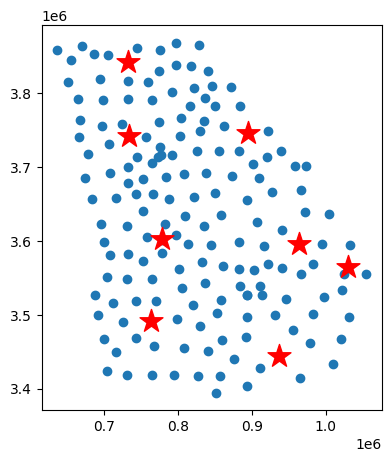

In [17]:
#Plot the faclities (stars) on top of the demand map.
fig, ax = plt.subplots(figsize=(5,5))

georgia_shp.centroid.plot(ax=ax)
fac_loc.centroid.plot(ax=ax,color="red",markersize=300,marker="*")